<a href="https://colab.research.google.com/github/jinieo/Final-Team6/blob/main/%ED%8C%8C%EC%9D%B4%EB%84%90%ED%94%84%EC%A0%9D_%ED%81%B4%EB%9F%AC%EC%8A%A4%ED%84%B0%EB%A7%81_%ED%98%9C%EC%A7%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/파이널프로젝트/combined_dataset_cleaned.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11446 entries, 0 to 11445
Data columns (total 46 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   id                                           11446 non-null  int64  
 1   host_id                                      11446 non-null  int64  
 2   host_since                                   11446 non-null  object 
 3   host_response_time                           10000 non-null  object 
 4   host_response_rate                           10000 non-null  object 
 5   host_acceptance_rate                         10641 non-null  object 
 6   host_is_superhost                            11173 non-null  object 
 7   host_neighbourhood                           10530 non-null  object 
 8   host_listings_count                          11446 non-null  int64  
 9   host_total_listings_count                    11446 non-null  int64  
 10

In [ ]:
df.dropna(subset=["review_scores_value"], inplace=True)

In [ ]:
df.isnull().sum().sort_values(ascending=False)

,0
host_response_rate,1031
host_response_time,1031
host_neighbourhood,739
price,731
host_acceptance_rate,486
has_availability,440
host_is_superhost,197
last_review,2
first_review,2
reviews_per_month,2


In [ ]:
df.shape

(9926, 46)

In [ ]:
# Null 값 집계
null_counts = df.isnull().sum()
print(null_counts)

id                                                0
host_id                                           0
host_since                                        0
host_response_time                             1031
host_response_rate                             1031
host_acceptance_rate                            486
host_is_superhost                               197
host_neighbourhood                              739
host_listings_count                               0
host_total_listings_count                         0
host_verifications                                0
host_identity_verified                            0
property_type                                     0
room_type                                         0
accommodates                                      0
price                                           731
minimum_nights                                    0
maximum_nights                                    0
minimum_minimum_nights                            1
maximum_mini

-------
#09/20 클러스터링 시도

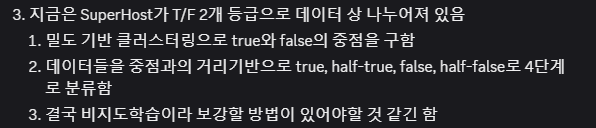

군집나누기 전에 관련 높은 변수를 찾아보려 함

In [ ]:
from scipy.stats import chi2_contingency

# 슈퍼호스트 숫자 변환
df["host_is_superhost_num"] = df["host_is_superhost"].map({"t": 1, "f": 0})

results = {}

# 1. 숫자형 변수는 피어슨 상관
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns
for col in numeric_cols:
    if col != "host_is_superhost_num":
        results[col] = abs(df[["host_is_superhost_num", col]].corr().iloc[0,1])

# 2. 범주형 변수는 카이제곱 검정 → Cramér’s V
cat_cols = df.select_dtypes(include=["object", "category"]).columns
for col in cat_cols:
    if col != "host_is_superhost":
        contingency = pd.crosstab(df[col], df["host_is_superhost_num"])
        chi2 = chi2_contingency(contingency)[0]
        n = contingency.sum().sum()
        k = min(contingency.shape)-1
        cramers_v = np.sqrt((chi2/n) / k)
        results[col] = cramers_v

# 상관 높은 TOP10
top10 = sorted(results.items(), key=lambda x: x[1], reverse=True)[:10]
print("Superhost와 가장 관련 높은 TOP10 변수")
for col, val in top10:
    print(f"{col}: {val:.3f}")


Superhost와 가장 관련 높은 TOP10 변수
host_since: 0.879
price: 0.705
first_review: 0.557
last_review: 0.437
review_scores_cleanliness: 0.311
number_of_reviews_ltm: 0.308
review_scores_rating: 0.306
host_response_rate: 0.285
host_acceptance_rate: 0.283
property_type: 0.267


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

In [ ]:
#한글 글씨 폰트 설치
%%capture
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fm.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumGothic.ttf')
plt.rcParams['font.family'] = 'NanumGothic'

# 표에서 ('-') 마이너스 표시
plt.rcParams['axes.unicode_minus'] = False

군집 생성을 위해 전처리 중에 알게 된 것이, TOP변수 중 하나인 **property_type**이 너무 자잘하고, 분류 중에
- `Room in serviced apartment`   
: 전체인지 쉐어인지 독립된건지 분류하기도 애매함..
- `Tiny home`  
: 작은 집이 그래서 쉐어인지 전체인지 어케 안다는 것임?;;  

위와 같이 애매한 값 이슈가 있었음, 그런데 **room_type**은 아래와 같이
깔끔한 4가지의 기준으로 구성됨,  
- `Entire home/apt`, `Private room`, `Hotel room`, `Shared room`  

그래서 property_type을 버리고 사용하기로 함

In [ ]:
df["property_type"].unique() #보다시피 굉장히 자잘함

array(['Entire rental unit', 'Entire serviced apartment',
       'Private room in rental unit', 'Entire condo', 'Entire loft',
       'Room in aparthotel', 'Shared room in bed and breakfast',
       'Private room in bed and breakfast', 'Room in serviced apartment',
       'Entire guest suite', 'Private room in serviced apartment',
       'Private room in home', 'Private room in condo',
       'Room in boutique hotel', 'Entire home', 'Private room in loft',
       'Private room in townhouse', 'Room in hotel', 'Entire townhouse',
       'Shared room in hostel', 'Houseboat', 'Entire bed and breakfast',
       'Private room in guest suite', 'Boat', 'Entire villa',
       'Shared room in rental unit', 'Private room in hostel',
       'Room in bed and breakfast', 'Room in hostel',
       'Private room in villa', 'Private room', 'Entire guesthouse',
       'Tiny home', 'Shared room in condo', 'Entire cottage',
       'Entire place', 'Private room in boat', 'Entire cabin',
       'Entire bunga

In [ ]:
df["room_type"].unique()

array(['Entire home/apt', 'Private room', 'Hotel room', 'Shared room'],
      dtype=object)

In [ ]:
df1 = df.copy()

In [ ]:
#데이터 전처리
# Superhost 변환
df1["host_is_superhost_num"] = df1["host_is_superhost"].map({"t": 1, "f": 0})

# 날짜형 처리 (년 단위 변환)
df1["host_since"] = pd.to_datetime(df1["host_since"], errors="coerce")
df1["first_review"] = pd.to_datetime(df1["first_review"], errors="coerce")
df1["last_review"] = pd.to_datetime(df1["last_review"], errors="coerce")

today = pd.to_datetime("today")

df1["host_since_years"] = (today - df1["host_since"]).dt.days / 365
df1["last_review_years"] = (today - df1["last_review"]).dt.days / 365
df1["first_review_years"] = (today - df1["first_review"]).dt.days / 365


# 가격(price) 달러랑 콤마,nan, 0 처리
df1["price"] = (
    df1["price"]
    .astype(str)
    .str.replace("[$,]", "", regex=True)   # 달러/콤마 제거
    .replace(["nan", "NaN", ""], "0")      # nan, 빈칸을 0으로
    .astype(float)
)

# 응답율(host_response_rate) 변환 (% → float)
df1["host_response_rate"] = (
    df1["host_response_rate"].astype(str)
    .str.replace("%", "", regex=True)
    .replace("nan", "0")
    .astype(float) / 100.0
)

# 예약수락율(host_acceptance_rate) 변환 (% → float)
df1["host_acceptance_rate"] = (
    df1["host_acceptance_rate"].astype(str)
    .str.replace("%", "", regex=True)
    .replace("nan", "0")
    .astype(float) / 100.0
)

# 숙소유형(property_type)->(room_type으로 대체함) 범주형 원핫인코딩
df1 = pd.get_dummies(df1, columns=["room_type"], drop_first=False)

#이상치 판단

시각화 해보니 이상치가 너무 많아서 군집이 이상한 이슈로 이상치 판단 시작...  
결과적으로 남은 건 심플한데 참..많은 이슈가 있었음 ㅋㅋㅎ
ㅋㅋㅋ..

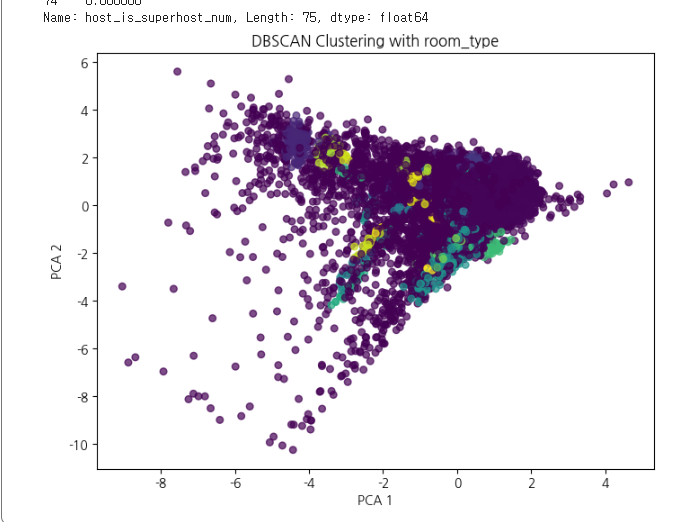

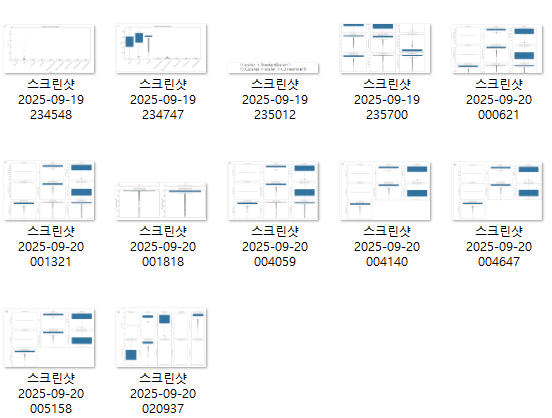

In [ ]:
#이상치 처리 레츠고

#가격IQR 사분위수
Q1 = df1["price"].quantile(0.25)
Q3 = df1["price"].quantile(0.75)
IQR = Q3 - Q1
df1 = df1[(df1["price"] >= Q1 - 1.5*IQR) & (df1["price"] <= Q3 + 1.5*IQR)].copy()

#가격 로그변환
df1.loc[:, "price_log"] = np.log1p(df1["price"])


#리뷰 로그변환
df1.loc[:, "number_of_reviews_ltm_log"] = np.log1p(df1["number_of_reviews_ltm"])

#리뷰IQR 사분위수
Q1 = df1["number_of_reviews_ltm_log"].quantile(0.25)
Q3 = df1["number_of_reviews_ltm_log"].quantile(0.75)
IQR = Q3 - Q1
df1 = df1[(df1["number_of_reviews_ltm_log"] >= Q1 - 1.5*IQR) &
        (df1["number_of_reviews_ltm_log"] <= Q3 + 1.5*IQR)].copy()

In [ ]:
#모델 입력값 준비
# X 정해주기
X = df1[[
    "host_since_years", "price_log", "first_review_years", "last_review_years",
    "review_scores_cleanliness", "number_of_reviews_ltm_log",
    "review_scores_rating"
    #"host_response_rate", "host_acceptance_rate" #쓸모없음
] + [col for col in df1.columns if col.startswith("room_type_")]].copy()

#결측처리
X = X.fillna(0)

#스케일링
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
df1["first_review"].unique()

<DatetimeArray>
['2010-09-20 00:00:00', '2010-05-07 00:00:00', '2015-05-19 00:00:00',
 '2011-03-21 00:00:00', '2010-08-18 00:00:00', '2010-11-04 00:00:00',
 '2010-10-25 00:00:00', '2011-04-04 00:00:00', '2016-08-22 00:00:00',
 '2011-04-05 00:00:00',
 ...
 '2023-03-08 00:00:00', '2023-03-09 00:00:00', '2023-03-20 00:00:00',
 '2023-05-18 00:00:00', '2014-08-05 00:00:00', '2015-08-20 00:00:00',
 '2016-06-07 00:00:00', '2016-10-18 00:00:00', '2017-04-11 00:00:00',
 '2022-04-22 00:00:00']
Length: 2710, dtype: datetime64[ns]

In [ ]:
df1["first_review_years"].unique()

array([15.01369863, 15.38630137, 10.35068493, ...,  8.93150685,
        8.45205479,  3.41917808])

In [ ]:
len(df1["first_review_years"].unique())

2710

In [ ]:
df1["last_review_years"].unique()

array([1.76164384, 1.49589041, 1.53424658, ..., 4.08767123, 6.18082192,
       2.58356164])

In [ ]:
df1["host_since_years"].unique()

array([16.77260274, 15.41643836, 15.15616438, ...,  2.10136986,
        4.58356164,  7.45753425])

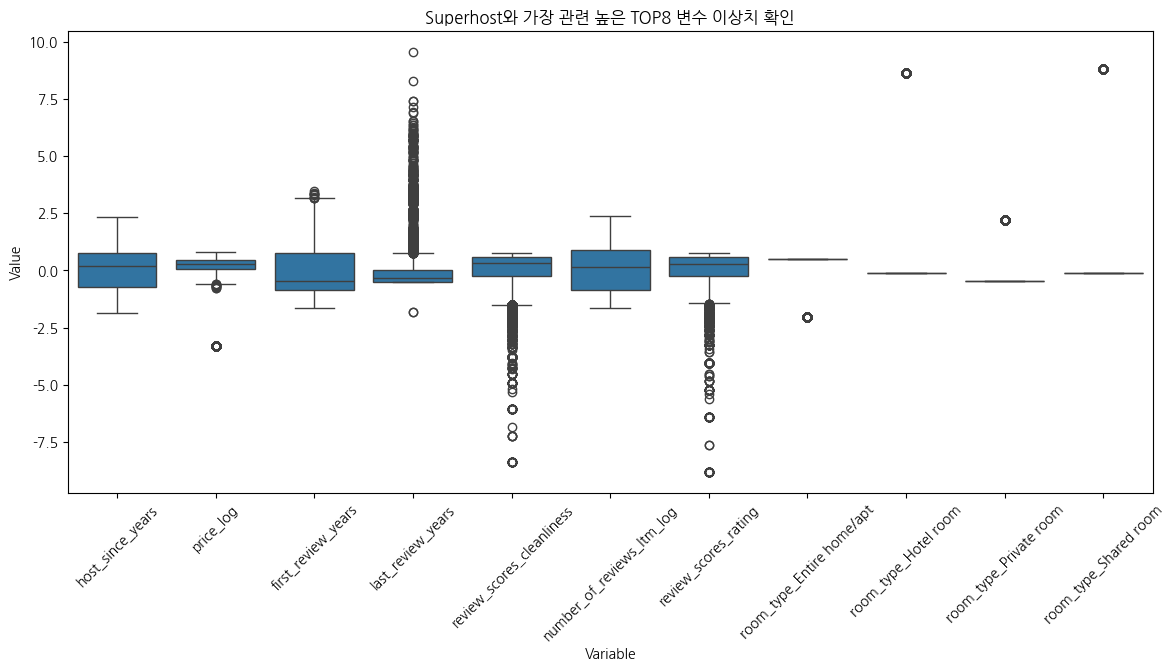

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# X_scaled를 DataFrame으로 변환 (이미 했다면 이 줄 생략 가능)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# long-format으로 변환
df_melted = X_scaled_df.melt(var_name="Variable", value_name="Value")

# 전체 boxplot 한 번에
plt.figure(figsize=(14, 6))
sns.boxplot(x="Variable", y="Value", data=df_melted)
plt.xticks(rotation=45)  # 가독성 위해 라벨 회전
plt.title("Superhost와 가장 관련 높은 TOP8 변수 이상치 확인")
plt.show()


#현 박스 플롯에서 나머지 이상치를 처리하지 않은 이유
##1. price_log (가격 로그 변환값)

극단적으로 높거나 낮은 가격대의 숙소는 실제 시장에서 존재할 수 있음 (럭셔리 숙소, 초저가 숙소).

로그 변환을 통해 이미 분포를 완화했기 때문에, 남아 있는 극단값은 데이터의 특성을 반영하는 실질적인 정보로 간주.
따라서 제거하지 않고 유지.

----

##2. first_review_years (첫 리뷰 이후 경과 연수)

첫 리뷰 시점이 매우 오래전이거나 최근인 경우는 호스트 운영 패턴에 큰 차이를 보여주는 핵심 변수.
오래된 계정이 슈퍼호스트일 가능성이 높다는 점을 고려하면, 극단값은 중요한 해석 포인트.

따라서 이상치 제거 대신 그대로 보존.

----


##3. last_review_years (마지막 리뷰 이후 경과 연수)

마지막 리뷰 시점이 매우 오래전이거나 최근인 경우는 호스트의 활동성을 잘 보여줌.

이 값이 크다는 건 사실상 운영이 중단된 계정일 수 있고, 이는 슈퍼호스트 여부와 직접 연결되는 특성.

따라서 이상치가 아니라 중요한 신호로 간주해 유지.

----


##4. review_scores_cleanliness (청결 점수)

대부분 호스트의 점수가 높은 구간에 몰려 있어 분포가 한쪽으로 치우쳐 보임.

하지만 드물게 낮은 청결 점수는 실제 게스트 경험을 반영한 중요한 극단 사례.

분포 특성상 이상치 제거 시 유용한 변별력을 잃을 수 있어 그대로 사용.

----


##5. review_scores_rating (종합 평점)

청결 점수와 유사하게 대부분 높은 점수(4.5~5)에 집중돼 있고, 낮은 평점(3 이하)은 드문 극단값으로 보임.

그러나 낮은 평점은 실제로 슈퍼호스트와 비슈퍼호스트를 구분하는 강력한 요인이므로 제거하지 않음.

따라서 그대로 보존.

#방 유형room type 쓸지 말지 고민
방 유형 작업할 때 범주형이어서 군집에는 못쓰겠다는 것을 알긴했으나,
일단 궁금해서 원앤핫을 했었고 랜덤포레스트를 돌려보는 등 실험을 해보았음

In [ ]:
#여기서 고민, 과연 room type은 필요할까
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd

# y 타깃 (슈퍼호스트 여부: 0/1)
y = df1["host_is_superhost_num"].fillna(0)

# 학습용 데이터 = 만들어둔 X_scaled사용
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 랜덤포레스트
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# 예측
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

from sklearn.model_selection import cross_val_score
import numpy as np

# 교차검증 (5-폴드)
scores = cross_val_score(rf, X_scaled, y, cv=5, scoring='accuracy')

# 소수점 셋째 자리까지 반올림
scores_rounded = np.round(scores, 3)

print("교차 검증 정확도:", scores_rounded)
print("평균 정확도: {:.3f} ± {:.3f}".format(np.mean(scores), np.std(scores)))

              precision    recall  f1-score   support

         0.0       0.83      0.89      0.86      1141
         1.0       0.80      0.71      0.75       719

    accuracy                           0.82      1860
   macro avg       0.81      0.80      0.81      1860
weighted avg       0.82      0.82      0.82      1860

교차 검증 정확도: [0.758 0.746 0.616 0.531 0.649]
평균 정확도: 0.660 ± 0.084


교차검증 결과, 평균 정확도 약 0.66으로 중간 수준.

여기서 room_type 변수 포함 여부가 성능에 큰 기여를 하지 않음을 확인
흑흑..그래서 빼기로 함

#room_type을 빼고 돌려보기_데이터 패턴 확인차 클러스터링

In [ ]:
X2 = X.drop(columns=[col for col in X.columns if col.startswith("room_type_")])
X2_scaled = scaler.fit_transform(X2)

   dbscan_no_room  superhost_ratio
0              -1         0.054945
1               0         0.421135
2               1         0.222059
3               2         0.166667
4               3         0.000000


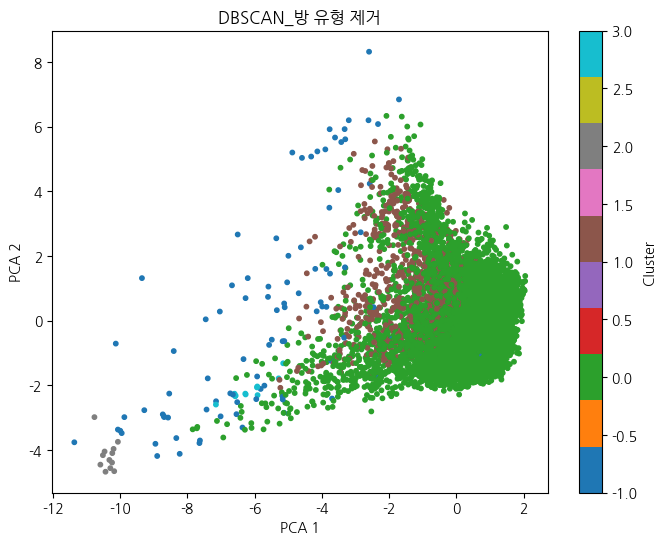

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

# DBSCAN 실행 (eps 값은 데이터 스케일에 따라 조정)
dbscan = DBSCAN(eps=1.5, min_samples=10)
df1["dbscan_no_room"] = dbscan.fit_predict(X2_scaled)

# 클러스터별 Superhost 비율
dbscan_stats = (
    df1.groupby("dbscan_no_room")["host_is_superhost_num"]
    .mean()
    .reset_index()
    .rename(columns={"host_is_superhost_num": "superhost_ratio"})
)
print(dbscan_stats)

# PCA 2D 시각화
pca = PCA(n_components=2)
X2_pca = pca.fit_transform(X2_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X2_pca[:,0], X2_pca[:,1], c=df1["dbscan_no_room"], cmap="tab10", s=10)
plt.title("DBSCAN_방 유형 제거")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="Cluster")
plt.show()


#DBSCAN으로 클러스터링이 잘 되지 않았음, 따라서 KMeans로 변경함

host_is_superhost_num       0.0       1.0
cluster_no_room                          
0                      0.575426  0.424574
1                      0.838975  0.161025
2                      0.486672  0.513328
3                      0.958264  0.041736


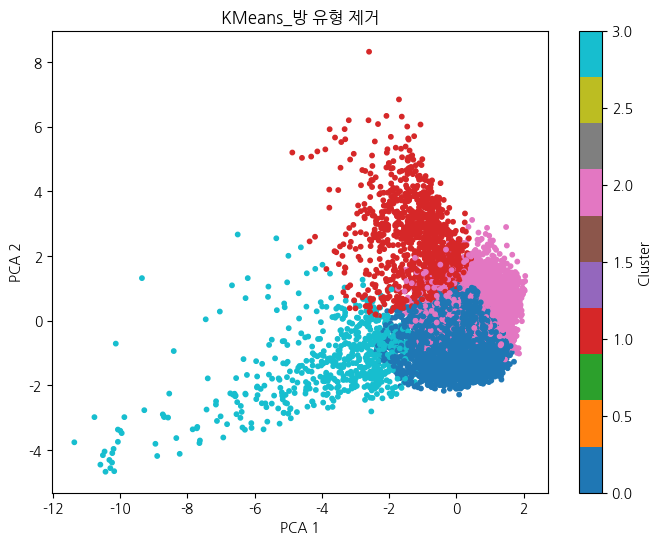

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 1. KMeans 클러스터링 (예: 4개 군집)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df1["cluster_no_room"] = kmeans.fit_predict(X2_scaled)

# 2. 클러스터별 Superhost 비율 확인
print(pd.crosstab(df1["cluster_no_room"], df1["host_is_superhost_num"], normalize="index"))

# 3. PCA 차원축소로 시각화
pca = PCA(n_components=2)
X2_pca = pca.fit_transform(X2_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X2_pca[:,0], X2_pca[:,1], c=df1["cluster_no_room"], cmap="tab10", s=10)
plt.title("KMeans_방 유형 제거")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="Cluster")
plt.show()


In [ ]:
import plotly.express as px
import pandas as pd
from sklearn.decomposition import PCA

# -----------------------------
# 1. PCA (3차원 축소)
# -----------------------------
pca = PCA(n_components=3)
X2_pca = pca.fit_transform(X2_scaled)

pca_df = pd.DataFrame(X2_pca, columns=["PCA1", "PCA2", "PCA3"])
pca_df["cluster"] = df1["cluster_no_room"]

# -----------------------------
# 2. 3D Scatter (인터랙티브)
# -----------------------------
fig = px.scatter_3d(
    pca_df,
    x="PCA1", y="PCA2", z="PCA3",
    color="cluster",
    opacity=0.5,                # 투명도 (겹침 완화)
    title="KMeans Clustering (PCA 3D Interactive)"
)

# 점 크기 줄이기
fig.update_traces(marker=dict(size=2))

# -----------------------------
# 3. 그래프 실행
# -----------------------------
fig.show()


In [ ]:
cluster_means = df1.groupby("cluster_no_room")[X2.columns].mean()
cluster_means

,host_since_years,price_log,first_review_years,last_review_years,review_scores_cleanliness,number_of_reviews_ltm_log,review_scores_rating
cluster_no_room,,,,,,,
0,5.948817,7.403514,2.712387,1.785336,4.767563,2.345789,4.782407
1,9.780997,4.815455,7.167010,4.514309,4.767066,0.179622,4.757093
2,11.117964,7.639115,7.065948,1.681597,4.726119,3.114730,4.744771
3,6.198662,6.158573,3.070085,2.259711,3.507677,1.189404,3.595228


#사용한 변수 다시 언급

호스트 등록일 `host_since`

가격 `price`

첫 리뷰 날짜  `first_review`

마지막 리뷰 날짜 `last_review`

청결도 평점 `review_scores_cleanliness`

지난 12개월 리뷰 수 `number_of_reviews_ltm`

전체 평점 `review_scores_rating`


# 클러스터링 집단 요약

Cluster 2 → 가장 슈퍼호스트에 가까운듯: 경험 오래됨, 가격대 높음, 리뷰 많고 최근에도 활동 활발, 평점 높음.

Cluster 1 → 은퇴한 호스트: 경력은 길지만 최근 활동이 거의 없음.

Cluster 0 → 평균적인 호스트: 가격대는 높은 편, 최근 활동 활발, 평점 높음.

Cluster 3 → 문제 호스트ㅋㅋ: 평점이 낮고 리뷰도 적은 신뢰도 낮은 호스트.

Cluster 0

host_since_years: 5.9 → 호스트 경험 보통

price_log: 7.40 → 가격 높음

first_review_years: 2.71, last_review_years: 1.78 → 리뷰가 최근에 몰려있음

number_of_reviews_ltm_log: 2.35 → 최근 12개월 리뷰 수 많음

review_scores_rating: 4.78 → 평점 매우 높음
👉 가격대가 높은 숙소 + 최근 리뷰 활동 많고 평점도 좋은 중급 경험자 호스트 그룹

----

Cluster 1

host_since_years: 9.78 → 호스트 경험 오래됨

price_log: 4.81 → 가격 낮음

first_review_years: 7.17, last_review_years: 4.51 → 리뷰 역사가 오래됨

number_of_reviews_ltm_log: 0.18 → 최근 리뷰 거의 없음

review_scores_rating: 4.76 → 평점 높음
👉 경력은 길지만 활동이 줄어든 저가 숙소 그룹 (슈퍼호스트 비율 낮을 가능성 높음)


----

Cluster 2

host_since_years: 11.1 → 가장 오래된 호스트

price_log: 7.63 → 가격 매우 높음

first_review_years: 7.06, last_review_years: 1.68 → 리뷰 역사는 길지만 최근 리뷰 있음

number_of_reviews_ltm_log: 3.11 → 최근 리뷰 활동 많음

review_scores_rating: 4.74 → 평점 높음
👉 경력 길고 고가 숙소 운영 + 최근에도 활발히 활동중인 파워 슈퍼호스트 가능성 높은 그룹

----

Cluster 3

host_since_years: 6.2 → 중간 정도 경험

price_log: 6.16 → 가격 중간

first_review_years: 3.07, last_review_years: 2.26 → 리뷰 최근

number_of_reviews_ltm_log: 1.18 → 리뷰 적음

review_scores_rating: 3.59 → 평점 낮음
👉 경험도 적고 평점 낮은 숙소 → 신뢰도 낮고 슈퍼호스트와 거리가 먼 그룹

#클러스터별 Superhost 비율 계산

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# -----------------------------
# 1. 클러스터별 Superhost 비율 계산
# -----------------------------
cluster_stats = (
    df1.groupby("cluster_no_room")["host_is_superhost_num"]
    .mean()
    .reset_index()
    .rename(columns={"host_is_superhost_num": "superhost_ratio"})
)

# -----------------------------
# 2. 4단계 레이블링 함수
# -----------------------------
def assign_label(ratio):
    if ratio >= 0.75:
        return "true"
    elif ratio >= 0.5:
        return "half-true"
    elif ratio >= 0.25:
        return "half-false"
    else:
        return "false"

#슈퍼호스트 4단계
cluster_stats["superhost_label_4"] = cluster_stats["superhost_ratio"].apply(assign_label)

# -----------------------------
# 3. 원본 df1에 병합
# -----------------------------
df1 = df1.merge(cluster_stats[["cluster_no_room", "superhost_label_4"]],
                on="cluster_no_room", how="left")

print(cluster_stats)
print(df1["superhost_label_4"].value_counts())

   cluster_no_room  superhost_ratio superhost_label_4
0                0         0.424574        half-false
1                1         0.161025             false
2                2         0.513328         half-true
3                3         0.041736             false
superhost_label_4
half-false    4034
half-true     3515
false         1748
Name: count, dtype: int64


In [ ]:
cluster_stats

,cluster_no_room,superhost_ratio,superhost_label_4
0,0,0.424574,half-false
1,1,0.161025,false
2,2,0.513328,half-true
3,3,0.041736,false


In [ ]:
df1["superhost_label_4"].value_counts()

,count
superhost_label_4,
half-false,4034
half-true,3515
false,1748


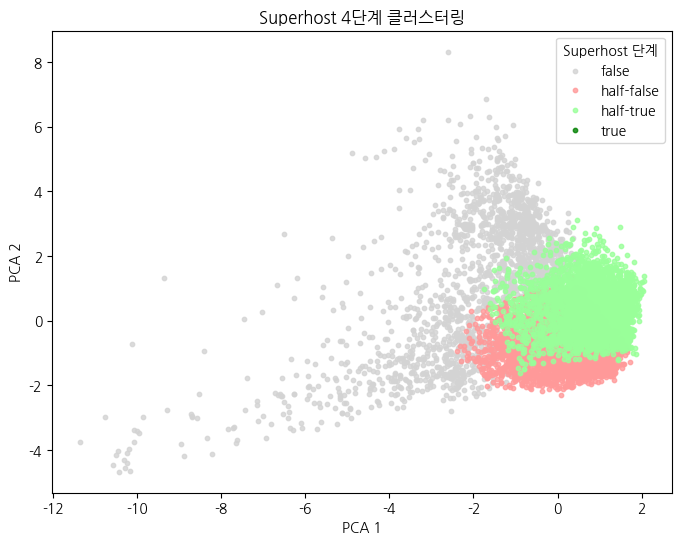

In [ ]:
import matplotlib.pyplot as plt

# 색상 매핑 (false=회색, half-false=연적색, half-true=연녹색, true=녹색)
color_map = {
    "false": "lightgray",
    "half-false": "#ff9999",   # 연한 적색
    "half-true": "#99ff99",    # 연한 녹색
    "true": "green"
}

# 시각화
plt.figure(figsize=(8,6))
for label, color in color_map.items():
    mask = df1["superhost_label_4"] == label
    plt.scatter(
        X2_pca[mask, 0],   # 첫 번째 주성분
        X2_pca[mask, 1],   # 두 번째 주성분
        c=color, label=label, s=10, alpha=0.8
    )

plt.title("Superhost 4단계 클러스터링")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Superhost 단계")
plt.show()


#Superhost 4단계 클러스터링 작업 결과
클러스터링 작업을 통해 True까지 영향을 미치는 강력한 것은 없지만 half-true까지 영향을 미치는 변수들이 존재함을 알 수 있었음

In [ ]:
# 1. 주요 변수들의 그룹별 평균
label_means = df1.groupby("superhost_label_4")[X2.columns].mean()

# 보기 좋게 round
label_means = label_means.round(3)

label_means

,host_since_years,price_log,first_review_years,last_review_years,review_scores_cleanliness,number_of_reviews_ltm_log,review_scores_rating
superhost_label_4,,,,,,,
false,8.476,5.305,5.674,3.693,4.308,0.548,4.334
half-false,5.949,7.404,2.712,1.785,4.768,2.346,4.782
half-true,11.118,7.639,7.066,1.682,4.726,3.115,4.745


review_scores_cleanliness의 차이는 미미해서 영향이 부족하다고 판단

#그룹별 변수 특성 요약

##false 그룹

host_since_years: 8.5년 → 계정은 오래되었지만,

price_log: 5.3 → 가격대 낮음

number_of_reviews_ltm_log: 0.55 → 최근 12개월 리뷰 거의 없음

review_scores_rating: 4.33 → 평점 낮음
→ 오래된 호스트지만 활동 적고 평점 낮아 Superhost 비율이 낮은 집단.

##half-false 그룹

host_since_years: 5.9년 → 운영기간 짧은 편

price_log: 7.4 → 상대적으로 가격대 높음

number_of_reviews_ltm_log: 2.35 → 리뷰는 꽤 있음

review_scores_rating: 4.78 → 평점 가장 높음
→ 신규지만 가격대 있고 평점/리뷰가 괜찮은편이라 Superhost 가능성이 중간 정도인 집단.

##half-true 그룹

host_since_years: 11.1년 → 가장 오래된 호스트

price_log: 7.6 → 가격대도 높음

number_of_reviews_ltm_log: 3.1 → 리뷰 활발

review_scores_rating: 4.75 → 평점 높음
→ 오래되고 가격도 높으며 활동 활발해 Superhost에 가까운 집단.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X2_scaled, df1["cluster_no_room"])
importances = pd.Series(rf.feature_importances_, index=X2.columns).sort_values(ascending=False)
print(importances)

first_review_years           0.281018
host_since_years             0.236096
number_of_reviews_ltm_log    0.143367
last_review_years            0.109917
review_scores_rating         0.094658
review_scores_cleanliness    0.088876
price_log                    0.046068
dtype: float64


클러스터별 특성 →

* 오래되었지만 활동 적은 그룹false 그룹
* 신규지만 평점 좋은 그룹 half-false 그룹
* 오래되었지만 활동이 활발함  half-true 그룹


변수 기여도 → 군집 구분에 있어 가장 큰 요인은 첫 리뷰 시점과 운영기간이었음.  
최근 리뷰 수와 최근 리뷰 시점도 주요한 기준이 되었음.  

----

인사이트 → 슈퍼호스트 가능성이 높은 그룹은 오래된 계정 + 활발한 리뷰 활동이 뒷받침된 경우임을 확인할 수 있음.

#비지도 학습을 어떻게 보완할까..?

In [ ]:
pd.crosstab(df1["superhost_label_4"], df1["host_is_superhost"], normalize="index")

host_is_superhost,f,t
superhost_label_4,,
false,0.881206,0.118794
half-false,0.575426,0.424574
half-true,0.486672,0.513328


In [ ]:
pd.DataFrame(X2_scaled, columns=X2.columns).isna().sum()

,0
host_since_years,0
price_log,0
first_review_years,0
last_review_years,0
review_scores_cleanliness,0
number_of_reviews_ltm_log,0
review_scores_rating,0


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

# --- 타겟 정의 (결측치 제거) ---
y = df1["host_is_superhost_num"]
mask = y.notna()
X_clean = X2_scaled[mask]
y_clean = y[mask]

# --- 데이터 분할 ---
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42, stratify=y_clean
)

# --- XGBoost 모델 정의 ---
xgb_model = XGBClassifier(
    eval_metric="logloss",
    random_state=42,
)

# --- 학습 ---
xgb_model.fit(X_train, y_train)

# --- 예측 ---
y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)[:, 1]

# --- 결과 출력 ---
print("===== XGBoost =====")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("ROC-AUC:", round(roc_auc_score(y_test, y_proba), 3))

===== XGBoost =====
Classification Report:
               precision    recall  f1-score   support

         0.0       0.86      0.90      0.88      1091
         1.0       0.83      0.78      0.81       732

    accuracy                           0.85      1823
   macro avg       0.85      0.84      0.84      1823
weighted avg       0.85      0.85      0.85      1823

Confusion Matrix:
 [[977 114]
 [160 572]]
Accuracy: 0.85
ROC-AUC: 0.914


입력(X):
* host_since_years
* price_log
* first_review_years
* last_review_years
* review_scores_cleanliness
* number_of_reviews_ltm_log
* review_scores_rating

정답(y): host_is_superhost_num (0=비슈퍼호스트, 1=슈퍼호스트)

지도학습 (XGBoost)를 활용해서
실제 슈퍼호스트 라벨로 검증해 보니,
모델이 85% 정확도로 예측 가능했고, ROC-AUC 0.914로 강한 분류력을 보였다.
보완 결론: 따라서 클러스터링에서 정의한 half-true 그룹은 실제 슈퍼호스트 집단과 유사하게 나타났으며,오래된 운영기간과 활발한 리뷰 활동이 핵심 요인임을 양쪽 분석에서 모두 확인할 수 있었다.